# Notebook 05: Zero-Inflated Count Models
## Modeling Excess Zeros with ZIP and ZINB

---

### Learning Objectives

By the end of this notebook, you will be able to:

1. **Recognize** excess zeros beyond what Poisson/NB models predict
2. **Understand** the two-process interpretation (structural vs sampling zeros)
3. **Estimate** Zero-Inflated Poisson (ZIP) models using PanelBox
4. **Estimate** Zero-Inflated Negative Binomial (ZINB) models
5. **Perform** the Vuong test to compare ZIP vs standard Poisson
6. **Interpret** results from two-part models
7. **Compute** predicted probabilities and decompose zeros

### Prerequisites

- **Conceptual**: Poisson and Negative Binomial regression (Notebooks 01-02)
- **Technical**: Logistic regression for binary outcomes
- **Helpful**: Familiarity with mixture models

### Duration

- **Estimated time**: 70 minutes
- **Difficulty**: Advanced

### Dataset

- **File**: `healthcare_zinb.csv` -- Healthcare utilization with excess zeros
- **N**: 3,000 individuals
- **Outcome**: `doctor_visits` (0-20, ~60% zeros)
- **Count covariates**: `age`, `income`, `chronic_condition`
- **Inflation covariates**: `insurance`, `distance_clinic`, `urban`

### References

- Lambert, D. (1992). *Zero-Inflated Poisson Regression.* Technometrics, 34(1), 1-14.
- Vuong, Q. H. (1989). *Likelihood Ratio Tests for Model Selection.* Econometrica, 307-333.
- Cameron, A. C. & Trivedi, P. K. (2013). *Regression Analysis of Count Data.* Cambridge.

## Setup

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.special import gammaln
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# PanelBox imports
from panelbox.models.count import (
    PooledPoisson,
    NegativeBinomial,
    ZeroInflatedPoisson,
    ZeroInflatedNegativeBinomial,
)

# Visualization configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Reproducibility
np.random.seed(42)

# Paths
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures' / '05_zinb'
TABLES_DIR = OUTPUT_DIR / 'tables' / '05_zinb'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')
print(f'Figures: {FIGURES_DIR}')
print(f'Tables: {TABLES_DIR}')

Setup complete!
Figures: ../outputs/figures/05_zinb
Tables: ../outputs/tables/05_zinb


In [2]:
# Load healthcare visits data
df = pd.read_csv(DATA_DIR / 'healthcare_zinb.csv')

print('Dataset shape:', df.shape)
print('\nFirst rows:')
display(df.head(10))

print('\nVariable descriptions:')
print('  doctor_visits:     Number of doctor visits in past year (count)')
print('  age:               Age in years (18-85)')
print('  income:            Annual income in thousands (10-150)')
print('  chronic_condition: Has chronic condition (1=Yes, 0=No)')
print('  insurance:         Has health insurance (1=Yes, 0=No)')
print('  distance_clinic:   Distance to nearest clinic in km')
print('  urban:             Urban residence (1=Yes, 0=No)')

print('\nSummary statistics:')
display(df.describe().round(2))

Dataset shape: (3000, 8)

First rows:


,individual_id,doctor_visits,age,income,chronic_condition,insurance,distance_clinic,urban
0,1,0,69,50.20,0,1,9.5,0
1,2,0,32,34.19,1,0,1.0,1
2,3,0,78,61.24,1,1,19.8,1
3,4,0,38,51.36,0,0,8.1,1
4,5,1,41,14.88,0,1,11.2,0
5,6,3,20,44.21,0,1,1.8,0
6,7,0,39,41.66,0,0,71.9,1
7,8,5,70,30.55,0,1,5.4,0
8,9,0,19,92.29,0,1,15.1,1
9,10,6,47,25.79,0,1,13.1,1



Variable descriptions:
  doctor_visits:     Number of doctor visits in past year (count)
  age:               Age in years (18-85)
  income:            Annual income in thousands (10-150)
  chronic_condition: Has chronic condition (1=Yes, 0=No)
  insurance:         Has health insurance (1=Yes, 0=No)
  distance_clinic:   Distance to nearest clinic in km
  urban:             Urban residence (1=Yes, 0=No)

Summary statistics:


,individual_id,doctor_visits,age,income,chronic_condition,insurance,distance_clinic,urban
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.0,3000.00
mean,1500.50,1.35,51.06,54.81,0.30,0.65,15.0,0.61
std,866.17,2.40,19.56,35.54,0.46,0.48,14.6,0.49
min,1.00,0.00,18.00,10.00,0.00,0.00,1.0,0.00
25%,750.75,0.00,34.00,28.33,0.00,0.00,4.4,0.00
50%,1500.50,0.00,51.00,45.18,0.00,1.00,10.5,1.00
75%,2250.25,2.00,68.00,71.33,1.00,1.00,20.4,1.00
max,3000.00,20.00,85.00,150.00,1.00,1.00,80.0,1.00


## Section 1: The Problem of Excess Zeros

### Why Standard Models Fail

Count data models (Poisson, NB) predict a certain proportion of zeros based on the estimated rate $\lambda$. When the **observed proportion of zeros far exceeds** what these models predict, we have **excess zeros** -- a sign that a different modeling approach is needed.

### Two Types of Zeros

1. **Structural zeros** ("never users"): Individuals who will *never* experience the event
   - No health insurance, live far from clinics, philosophically opposed to medicine
   - These zeros come from a fundamentally different population

2. **Sampling zeros** ("potential users"): Individuals who *could* experience the event but happened not to
   - Have insurance and access, but just didn't need to visit the doctor this year
   - These zeros arise naturally from the Poisson/NB process

**Key insight**: We cannot directly observe which type a zero belongs to -- this is a latent (unobserved) classification that the model must estimate.

In [3]:
# Quantify the excess zero problem
n_zeros = (df['doctor_visits'] == 0).sum()
pct_zeros = (df['doctor_visits'] == 0).mean() * 100
mean_visits = df['doctor_visits'].mean()
var_visits = df['doctor_visits'].var()

# What would Poisson predict for P(Y=0)?
poisson_zero_prob = np.exp(-mean_visits) * 100

print('=' * 70)
print('EXCESS ZERO ANALYSIS')
print('=' * 70)
print(f'\nTotal observations: {len(df):,}')
print(f'Number of zeros: {n_zeros:,}')
print(f'Observed zero proportion: {pct_zeros:.1f}%')
print(f'\nMean visits: {mean_visits:.3f}')
print(f'Variance: {var_visits:.3f}')
print(f'Var/Mean ratio: {var_visits / mean_visits:.2f} (overdispersion)')
print(f'\nPoisson predicted P(Y=0): {poisson_zero_prob:.1f}%')
print(f'Observed P(Y=0): {pct_zeros:.1f}%')
print(f'\nExcess zeros: {pct_zeros - poisson_zero_prob:.1f} percentage points')
print(f'Ratio: {pct_zeros / poisson_zero_prob:.1f}x more zeros than Poisson predicts')
print('\n--> Strong evidence of zero-inflation!')
print('=' * 70)

EXCESS ZERO ANALYSIS

Total observations: 3,000
Number of zeros: 1,862
Observed zero proportion: 62.1%

Mean visits: 1.352
Variance: 5.774
Var/Mean ratio: 4.27 (overdispersion)

Poisson predicted P(Y=0): 25.9%
Observed P(Y=0): 62.1%

Excess zeros: 36.2 percentage points
Ratio: 2.4x more zeros than Poisson predicts

--> Strong evidence of zero-inflation!


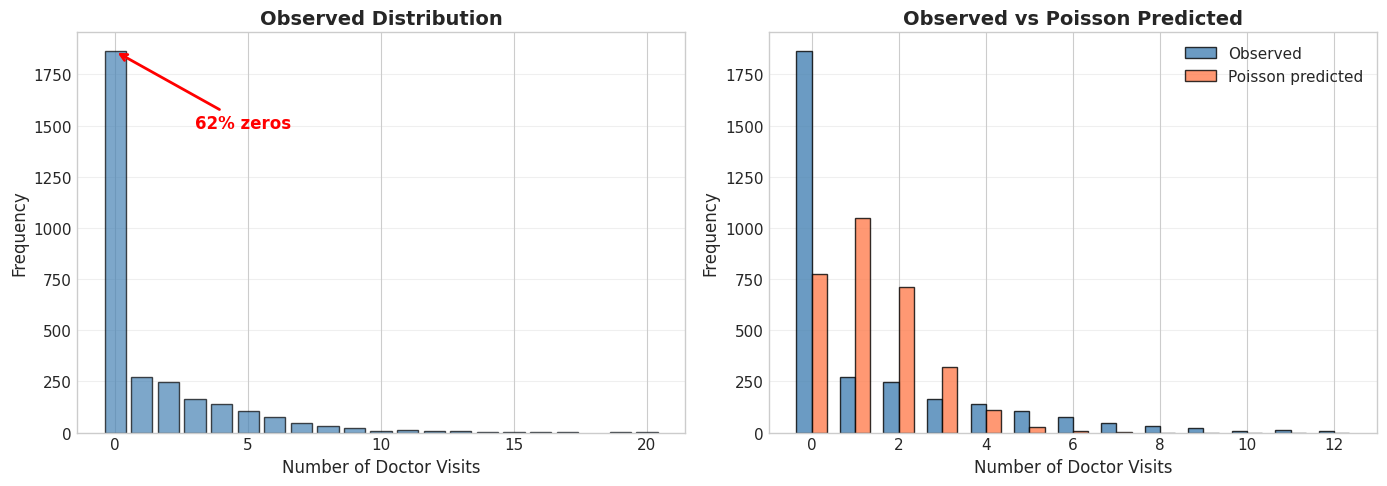

The tall bar at zero (left) far exceeds Poisson predictions (right).
This is the hallmark of zero-inflated data.


In [4]:
# Visualize the excess zeros
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Observed distribution
visit_counts = df['doctor_visits'].value_counts().sort_index()
axes[0].bar(visit_counts.index, visit_counts.values,
            edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Number of Doctor Visits', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Observed Distribution', fontsize=14, fontweight='bold')
axes[0].annotate(f'{pct_zeros:.0f}% zeros', xy=(0, visit_counts.get(0, 0)),
                 xytext=(3, visit_counts.get(0, 0) * 0.8),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=12, color='red', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Right: Observed vs Poisson predicted
max_count = int(df['doctor_visits'].quantile(0.99)) + 1
x_vals = np.arange(0, max_count + 1)
observed_freq = np.array([(df['doctor_visits'] == k).sum() for k in x_vals])
poisson_freq = len(df) * stats.poisson.pmf(x_vals, mean_visits)

width = 0.35
axes[1].bar(x_vals - width / 2, observed_freq, width, label='Observed',
            color='steelblue', alpha=0.8, edgecolor='black')
axes[1].bar(x_vals + width / 2, poisson_freq, width, label='Poisson predicted',
            color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Number of Doctor Visits', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Observed vs Poisson Predicted', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'visits_histogram_excess_zeros.png', dpi=300, bbox_inches='tight')
plt.show()

print('The tall bar at zero (left) far exceeds Poisson predictions (right).')
print('This is the hallmark of zero-inflated data.')

In [5]:
# Examine zeros by subgroups -- motivate two processes
print('ZERO VISIT RATES BY SUBGROUP')
print('=' * 70)

groups = {
    'Insurance': ('insurance', {0: 'No insurance', 1: 'Has insurance'}),
    'Chronic Condition': ('chronic_condition', {0: 'No chronic', 1: 'Has chronic'}),
    'Residence': ('urban', {0: 'Rural', 1: 'Urban'}),
}

zero_table_rows = []
for label, (col, mapping) in groups.items():
    for val, name in mapping.items():
        subset = df[df[col] == val]
        zero_rate = (subset['doctor_visits'] == 0).mean() * 100
        mean_v = subset['doctor_visits'].mean()
        zero_table_rows.append({
            'Group': label,
            'Category': name,
            'N': len(subset),
            'Zero Rate (%)': zero_rate,
            'Mean Visits': mean_v,
        })

zero_table = pd.DataFrame(zero_table_rows)
display(zero_table.round(2))

# Save table
zero_table.to_csv(TABLES_DIR / 'table_01_zero_proportions.csv', index=False)

print('\nKey observations:')
print('  - Uninsured: ~79% zeros vs insured: ~53% zeros')
print('  - Rural: ~70% zeros vs urban: ~57% zeros')
print('  - Different characteristics predict zero vs count intensity')
print('  --> Motivates a two-process model!')

ZERO VISIT RATES BY SUBGROUP


,Group,Category,N,Zero Rate (%),Mean Visits
0,Insurance,No insurance,1058,78.73,0.77
1,Insurance,Has insurance,1942,52.99,1.67
2,Chronic Condition,No chronic,2085,64.51,1.04
3,Chronic Condition,Has chronic,915,56.50,2.07
4,Residence,Rural,1163,69.82,1.06
5,Residence,Urban,1837,57.16,1.54



Key observations:
  - Uninsured: ~79% zeros vs insured: ~53% zeros
  - Rural: ~70% zeros vs urban: ~57% zeros
  - Different characteristics predict zero vs count intensity
  --> Motivates a two-process model!


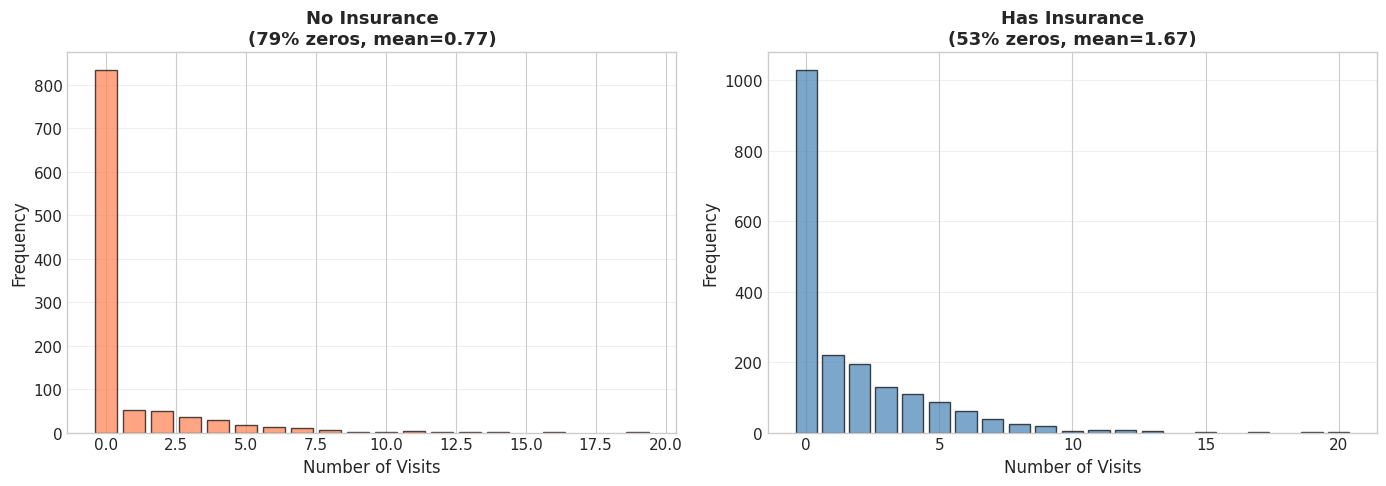

Uninsured individuals have far more zeros -- many are structural zeros.
Insured individuals still have zeros, but more of these are sampling zeros.


In [6]:
# Visualize zeros by insurance status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (val, label, color) in enumerate([(0, 'No Insurance', 'coral'),
                                            (1, 'Has Insurance', 'steelblue')]):
    subset = df[df['insurance'] == val]['doctor_visits']
    counts = subset.value_counts().sort_index()
    axes[idx].bar(counts.index, counts.values, color=color, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Number of Visits', fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    zero_pct = (subset == 0).mean() * 100
    axes[idx].set_title(f'{label}\n({zero_pct:.0f}% zeros, mean={subset.mean():.2f})',
                        fontsize=13, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'zeros_by_insurance.png', dpi=300, bbox_inches='tight')
plt.show()

print('Uninsured individuals have far more zeros -- many are structural zeros.')
print('Insured individuals still have zeros, but more of these are sampling zeros.')

## Section 2: Zero-Inflated Poisson (ZIP) Model

### Mathematical Specification

The ZIP model combines two processes:

**1. Inflation component (Logit)**: Probability of being a structural zero ("never user")
$$\pi_i = P(\text{structural zero}) = \frac{1}{1 + \exp(-\mathbf{Z}_i' \boldsymbol{\gamma})}$$

**2. Count component (Poisson)**: Count distribution for potential users
$$\lambda_i = \exp(\mathbf{X}_i' \boldsymbol{\beta})$$

### Combined Probabilities

$$P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}$$

$$P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad k > 0$$

### Interpretation

- **$\gamma$ coefficients** (inflation): Effect on log-odds of being a structural zero
  - $\gamma > 0$: Increases probability of being a never-user
  - Example: Greater distance to clinic increases P(never-user)

- **$\beta$ coefficients** (count): Effect on count for potential users
  - Same interpretation as standard Poisson (for participants)
  - Example: Chronic condition increases visit intensity

### Key Feature

The inflation covariates $\mathbf{Z}$ can (and often should) **differ** from the count covariates $\mathbf{X}$. This allows different factors to drive participation vs intensity.

In [7]:
# Fit baseline Poisson model first
y = df['doctor_visits'].values

# Count model covariates: age, income, chronic_condition
X_count = sm.add_constant(df[['age', 'income', 'chronic_condition']].values)
count_names = ['const', 'age', 'income', 'chronic']

# Inflation model covariates: insurance, distance_clinic, urban
X_inflate = sm.add_constant(df[['insurance', 'distance_clinic', 'urban']].values)
inflate_names = ['const', 'insurance', 'distance', 'urban']

print('Fitting baseline Poisson model...')
poisson_model = PooledPoisson(endog=y, exog=X_count)
poisson_result = poisson_model.fit(se_type='robust')
poisson_llf = poisson_model.llf

print('Poisson Results:')
print(poisson_result.summary())
print(f'\nLog-likelihood: {poisson_llf:.2f}')

Fitting baseline Poisson model...
Poisson Results:

Model Results
Number of Obs: 3000
Number of Parameters: 4

Parameter Estimates:
-------------------
  Param 0: -0.4934 (SE: 0.0557, t: -8.86, p: 0.0000)
  Param 1: 0.0131 (SE: 0.0008, t: 16.03, p: 0.0000)
  Param 2: -0.0032 (SE: 0.0005, t: -6.82, p: 0.0000)
  Param 3: 0.6915 (SE: 0.0315, t: 21.97, p: 0.0000)


Log-likelihood: -6214.91


In [8]:
# Fit Zero-Inflated Poisson (ZIP) model using PanelBox
print('Estimating Zero-Inflated Poisson (ZIP) model...')
print('  Count model covariates: age, income, chronic_condition')
print('  Inflation model covariates: insurance, distance_clinic, urban')
print()

zip_model = ZeroInflatedPoisson(
    endog=y,
    exog_count=X_count,
    exog_inflate=X_inflate,
    exog_count_names=count_names,
    exog_inflate_names=inflate_names,
)

zip_result = zip_model.fit()

print('ZIP estimation complete!')
print(f'Converged: {zip_result.converged}')
print(f'Iterations: {zip_result.iterations}')
print()
print(zip_result.summary())

Estimating Zero-Inflated Poisson (ZIP) model...
  Count model covariates: age, income, chronic_condition
  Inflation model covariates: insurance, distance_clinic, urban



ZIP estimation complete!
Converged: True
Iterations: 18

Zero-Inflated Poisson Model Results
Number of observations: 3000
Log-likelihood: -4192.5927
AIC: 8401.1855
BIC: 8449.2364
Converged: True

Actual proportion of zeros: 0.6207
Predicted proportion of zeros: 0.6198

Vuong test (ZIP vs Poisson):
  Statistic: 25.7010
  p-value: 0.0000
  --> ZIP is preferred over standard Poisson

----------------------------------------------------------------------
Count Model (Poisson)
----------------------------------------------------------------------
Variable             Coef         Std.Err      z          P>|z|     
const                0.4527       0.0615       7.367      0.0000    
age                  0.0121       0.0009       13.663     0.0000    
income               -0.0023      0.0005       -4.564     0.0000    
chronic              0.5574       0.0335       16.615     0.0000    

----------------------------------------------------------------------
Zero-Inflation Model (Logit)
------

In [9]:
# Create detailed coefficient tables for both components
def add_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

# Count model table
z_count = zip_result.params_count / zip_result.bse_count
p_count = 2 * (1 - stats.norm.cdf(np.abs(z_count)))

count_table = pd.DataFrame({
    'Variable': count_names,
    'Coefficient': zip_result.params_count,
    'Std. Error': zip_result.bse_count,
    'z-stat': z_count,
    'p-value': p_count,
    'IRR': np.exp(zip_result.params_count),
    'Sig': [add_stars(p) for p in p_count],
})

print('COUNT MODEL PARAMETERS (Poisson component)')
print('Interpretation: Effect on visit rate among potential users')
print('=' * 80)
display(count_table.round(4))
count_table.to_csv(TABLES_DIR / 'table_02_zip_count_params.csv', index=False)

print()

# Inflation model table
z_inflate = zip_result.params_inflate / zip_result.bse_inflate
p_inflate = 2 * (1 - stats.norm.cdf(np.abs(z_inflate)))

inflate_table = pd.DataFrame({
    'Variable': inflate_names,
    'Coefficient': zip_result.params_inflate,
    'Std. Error': zip_result.bse_inflate,
    'z-stat': z_inflate,
    'p-value': p_inflate,
    'Odds Ratio': np.exp(zip_result.params_inflate),
    'Sig': [add_stars(p) for p in p_inflate],
})

print('INFLATION MODEL PARAMETERS (Logit component)')
print('Interpretation: Effect on log-odds of being a structural zero')
print('Positive = increases probability of NEVER using healthcare')
print('=' * 80)
display(inflate_table.round(4))
inflate_table.to_csv(TABLES_DIR / 'table_03_zip_inflate_params.csv', index=False)

COUNT MODEL PARAMETERS (Poisson component)
Interpretation: Effect on visit rate among potential users


,Variable,Coefficient,Std. Error,z-stat,p-value,IRR,Sig
0,const,0.4527,0.0615,7.3674,0.0,1.5726,***
1,age,0.0121,0.0009,13.6629,0.0,1.0122,***
2,income,-0.0023,0.0005,-4.5638,0.0,0.9977,***
3,chronic,0.5574,0.0335,16.6147,0.0,1.7461,***



INFLATION MODEL PARAMETERS (Logit component)
Interpretation: Effect on log-odds of being a structural zero
Positive = increases probability of NEVER using healthcare


,Variable,Coefficient,Std. Error,z-stat,p-value,Odds Ratio,Sig
0,const,1.1266,0.1036,10.8732,0.0,3.0852,***
1,insurance,-1.2931,0.0941,-13.7397,0.0,0.2744,***
2,distance,0.0377,0.0035,10.7737,0.0,1.0384,***
3,urban,-0.6304,0.0885,-7.1228,0.0,0.5324,***


In [10]:
# Interpret key coefficients
print('INTERPRETATION OF ZIP RESULTS')
print('=' * 70)

print('\n--- Inflation Model (who is a never-user?) ---')
for i, name in enumerate(inflate_names):
    coef = zip_result.params_inflate[i]
    odds_r = np.exp(coef)
    if name == 'const':
        continue
    direction = 'increases' if coef > 0 else 'decreases'
    print(f'  {name}: gamma={coef:.3f} (OR={odds_r:.3f})')
    if name == 'insurance':
        print(f'    Insurance {direction} P(structural zero)')
        print(f'    Having insurance reduces odds of being a never-user')
    elif name == 'distance':
        print(f'    Greater distance {direction} P(structural zero)')
        print(f'    Access barriers make never-use more likely')
    elif name == 'urban':
        print(f'    Urban residence {direction} P(structural zero)')
        print(f'    Urban areas have better access')

print('\n--- Count Model (how many visits among users?) ---')
for i, name in enumerate(count_names):
    coef = zip_result.params_count[i]
    irr = np.exp(coef)
    if name == 'const':
        continue
    print(f'  {name}: beta={coef:.4f} (IRR={irr:.3f})')
    if name == 'age':
        print(f'    Each year of age: {(irr-1)*100:.1f}% change in visits')
    elif name == 'chronic':
        print(f'    Chronic condition: {(irr-1)*100:.1f}% more visits')
    elif name == 'income':
        print(f'    Each $1K income: {(irr-1)*100:.2f}% change in visits')

print('\n' + '=' * 70)

INTERPRETATION OF ZIP RESULTS

--- Inflation Model (who is a never-user?) ---
  insurance: gamma=-1.293 (OR=0.274)
    Insurance decreases P(structural zero)
    Having insurance reduces odds of being a never-user
  distance: gamma=0.038 (OR=1.038)
    Greater distance increases P(structural zero)
    Access barriers make never-use more likely
  urban: gamma=-0.630 (OR=0.532)
    Urban residence decreases P(structural zero)
    Urban areas have better access

--- Count Model (how many visits among users?) ---
  age: beta=0.0121 (IRR=1.012)
    Each year of age: 1.2% change in visits
  income: beta=-0.0023 (IRR=0.998)
    Each $1K income: -0.23% change in visits
  chronic: beta=0.5574 (IRR=1.746)
    Chronic condition: 74.6% more visits



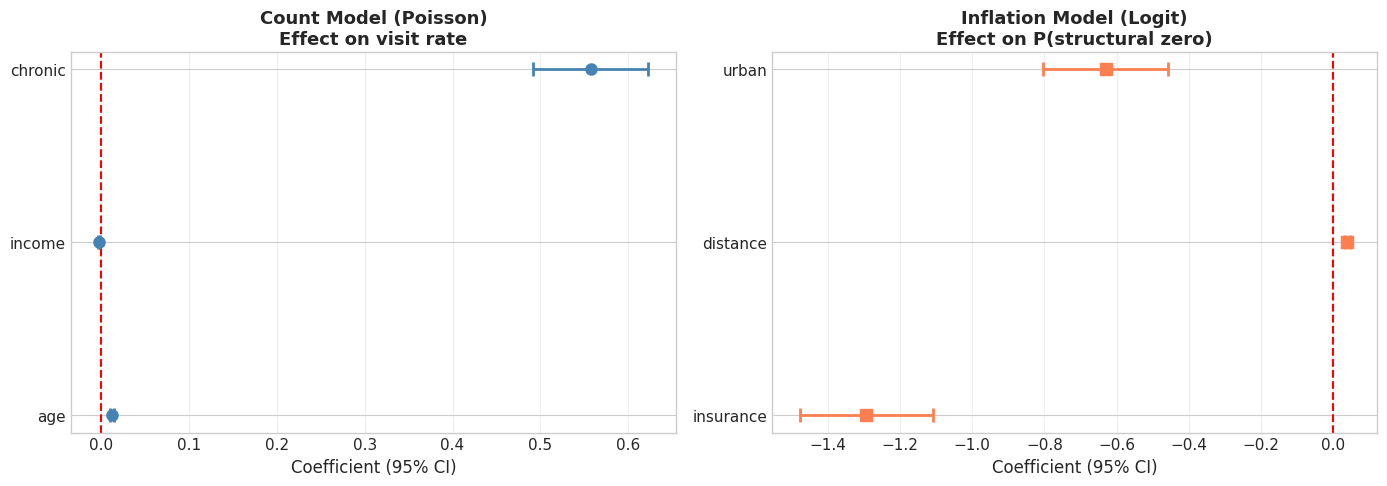

In [11]:
# Dual forest plot: count and inflation coefficients
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count model (exclude constant)
ax = axes[0]
names_c = count_names[1:]
coefs_c = zip_result.params_count[1:]
ses_c = zip_result.bse_count[1:]
y_pos_c = np.arange(len(names_c))

ax.errorbar(coefs_c, y_pos_c, xerr=1.96 * ses_c,
            fmt='o', markersize=8, capsize=5, capthick=2,
            linewidth=2, color='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
ax.set_yticks(y_pos_c)
ax.set_yticklabels(names_c)
ax.set_xlabel('Coefficient (95% CI)', fontsize=12)
ax.set_title('Count Model (Poisson)\nEffect on visit rate', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Inflation model (exclude constant)
ax = axes[1]
names_i = inflate_names[1:]
coefs_i = zip_result.params_inflate[1:]
ses_i = zip_result.bse_inflate[1:]
y_pos_i = np.arange(len(names_i))

ax.errorbar(coefs_i, y_pos_i, xerr=1.96 * ses_i,
            fmt='s', markersize=8, capsize=5, capthick=2,
            linewidth=2, color='coral')
ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
ax.set_yticks(y_pos_i)
ax.set_yticklabels(names_i)
ax.set_xlabel('Coefficient (95% CI)', fontsize=12)
ax.set_title('Inflation Model (Logit)\nEffect on P(structural zero)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'zip_coefficients_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Zero-Inflated Negative Binomial (ZINB)

### Why ZINB?

ZIP assumes **equidispersion** in the count part. If overdispersion remains among the non-zero counts (Var > Mean), we need ZINB.

### Specification

ZINB adds an overdispersion parameter $\alpha$ to the count component:

- **Inflation**: Same logit as ZIP
- **Count**: NB instead of Poisson: $\text{Var}[Y | \text{user}] = \mu + \alpha \mu^2$
- **Parameters**: $[\boldsymbol{\beta}_{\text{count}}, \boldsymbol{\gamma}_{\text{inflate}}, \alpha_{\text{dispersion}}]$

If $\alpha \approx 0$, ZINB reduces to ZIP.

In [12]:
# Check for overdispersion among non-zero counts
nonzero = df[df['doctor_visits'] > 0]['doctor_visits']

print('OVERDISPERSION IN NON-ZERO COUNTS')
print('=' * 50)
print(f'N non-zero observations: {len(nonzero)}')
print(f'Mean (non-zero): {nonzero.mean():.3f}')
print(f'Variance (non-zero): {nonzero.var():.3f}')
print(f'Var/Mean ratio: {nonzero.var() / nonzero.mean():.3f}')

if nonzero.var() / nonzero.mean() > 1.5:
    print('\n--> Overdispersion present among non-zero counts!')
    print('--> ZINB may be more appropriate than ZIP')
else:
    print('\n--> Mild or no overdispersion. ZIP may suffice.')
print('=' * 50)

OVERDISPERSION IN NON-ZERO COUNTS
N non-zero observations: 1138
Mean (non-zero): 3.563
Variance (non-zero): 7.342
Var/Mean ratio: 2.060

--> Overdispersion present among non-zero counts!
--> ZINB may be more appropriate than ZIP


In [13]:
# Fit Zero-Inflated Negative Binomial (ZINB) model
print('Estimating Zero-Inflated Negative Binomial (ZINB) model...')
print('  Same covariates as ZIP')
print('  Additional parameter: alpha (overdispersion)')
print()

zinb_model = ZeroInflatedNegativeBinomial(
    endog=y,
    exog_count=X_count,
    exog_inflate=X_inflate,
    exog_count_names=count_names,
    exog_inflate_names=inflate_names,
)

zinb_result = zinb_model.fit()

print('ZINB estimation complete!')
print(f'Converged: {zinb_result.converged}')
print()
print(zinb_result.summary())

Estimating Zero-Inflated Negative Binomial (ZINB) model...
  Same covariates as ZIP
  Additional parameter: alpha (overdispersion)



ZINB estimation complete!
Converged: True

Zero-Inflated Negative Binomial Model Results
Number of observations: 3000
Log-likelihood: -4071.0526
AIC: 8160.1051
BIC: 8214.1624
Alpha (overdispersion): 0.3164
Converged: True

Actual proportion of zeros: 0.6207
Predicted proportion of zeros: 0.6202

----------------------------------------------------------------------
Count Model (Negative Binomial)
----------------------------------------------------------------------
Variable             Coef         Std.Err      z          P>|z|     
const                0.2978       0.0870       3.422      0.0006    
age                  0.0131       0.0013       10.200     0.0000    
income               -0.0026      0.0007       -3.563     0.0004    
chronic              0.6218       0.0503       12.372     0.0000    

----------------------------------------------------------------------
Zero-Inflation Model (Logit)
----------------------------------------------------------------------
Variable    

In [14]:
# Save ZINB results
zinb_count_z = zinb_result.params_count / zinb_result.bse_count
zinb_count_p = 2 * (1 - stats.norm.cdf(np.abs(zinb_count_z)))
zinb_inflate_z = zinb_result.params_inflate / zinb_result.bse_inflate
zinb_inflate_p = 2 * (1 - stats.norm.cdf(np.abs(zinb_inflate_z)))

zinb_table = pd.DataFrame({
    'Component': (['Count'] * len(count_names) + ['Inflate'] * len(inflate_names)),
    'Variable': count_names + inflate_names,
    'Coefficient': np.concatenate([zinb_result.params_count, zinb_result.params_inflate]),
    'Std. Error': np.concatenate([zinb_result.bse_count, zinb_result.bse_inflate]),
    'z-stat': np.concatenate([zinb_count_z, zinb_inflate_z]),
    'p-value': np.concatenate([zinb_count_p, zinb_inflate_p]),
})

zinb_table.to_csv(TABLES_DIR / 'table_04_zinb_results.csv', index=False)

print('ZINB Detailed Results')
print('=' * 80)
display(zinb_table.round(4))

print(f'\nOverdispersion parameter alpha: {zinb_result.alpha:.4f}')
if zinb_result.alpha < 0.01:
    print('  Alpha near zero: ZIP is sufficient (no overdispersion in count part)')
elif zinb_result.alpha < 0.5:
    print('  Mild overdispersion in count part')
else:
    print('  Substantial overdispersion in count part -- ZINB preferred')

ZINB Detailed Results


,Component,Variable,Coefficient,Std. Error,z-stat,p-value
0,Count,const,0.2978,0.0870,3.4216,0.0006
1,Count,age,0.0131,0.0013,10.1995,0.0000
2,Count,income,-0.0026,0.0007,-3.5628,0.0004
3,Count,chronic,0.6218,0.0503,12.3716,0.0000
4,Inflate,const,1.0090,0.1107,9.1134,0.0000
5,Inflate,insurance,-1.4050,0.1024,-13.7190,0.0000
6,Inflate,distance,0.0407,0.0038,10.7232,0.0000
7,Inflate,urban,-0.6936,0.0971,-7.1426,0.0000



Overdispersion parameter alpha: 0.3164
  Mild overdispersion in count part


In [15]:
# Compare ZIP vs ZINB coefficients
comparison_df = pd.DataFrame({
    'Variable': count_names + inflate_names,
    'Component': ['Count'] * len(count_names) + ['Inflate'] * len(inflate_names),
    'ZIP_Coef': np.concatenate([zip_result.params_count, zip_result.params_inflate]),
    'ZIP_SE': np.concatenate([zip_result.bse_count, zip_result.bse_inflate]),
    'ZINB_Coef': np.concatenate([zinb_result.params_count, zinb_result.params_inflate]),
    'ZINB_SE': np.concatenate([zinb_result.bse_count, zinb_result.bse_inflate]),
})
comparison_df['Diff'] = comparison_df['ZINB_Coef'] - comparison_df['ZIP_Coef']

print('ZIP vs ZINB Coefficient Comparison')
print('=' * 80)
display(comparison_df.round(4))
comparison_df.to_csv(TABLES_DIR / 'table_05_zip_vs_zinb_comparison.csv', index=False)

print('\nCoefficients are generally similar between ZIP and ZINB.')
print('Standard errors may differ when overdispersion is substantial.')

ZIP vs ZINB Coefficient Comparison


,Variable,Component,ZIP_Coef,ZIP_SE,ZINB_Coef,ZINB_SE,Diff
0,const,Count,0.4527,0.0615,0.2978,0.0870,-0.1549
1,age,Count,0.0121,0.0009,0.0131,0.0013,0.0010
2,income,Count,-0.0023,0.0005,-0.0026,0.0007,-0.0002
3,chronic,Count,0.5574,0.0335,0.6218,0.0503,0.0644
4,const,Inflate,1.1266,0.1036,1.0090,0.1107,-0.1176
5,insurance,Inflate,-1.2931,0.0941,-1.4050,0.1024,-0.1119
6,distance,Inflate,0.0377,0.0035,0.0407,0.0038,0.0030
7,urban,Inflate,-0.6304,0.0885,-0.6936,0.0971,-0.0632



Coefficients are generally similar between ZIP and ZINB.
Standard errors may differ when overdispersion is substantial.


## Section 4: Model Comparison -- Vuong Test

### Vuong Test for Non-nested Model Comparison

The **Vuong (1989) test** compares the ZIP model against standard Poisson:

$$V = \frac{\sqrt{N} \cdot \bar{m}}{s_m}$$

where $m_i = \ell_{\text{ZIP},i} - \ell_{\text{Poisson},i}$ is the per-observation log-likelihood difference.

- $V > 1.96$: ZIP is preferred
- $V < -1.96$: Poisson is preferred
- $|V| < 1.96$: Models are indistinguishable

### Information Criteria

We also compare models using AIC and BIC across all four specifications:
Poisson, NB, ZIP, and ZINB.

In [16]:
# Vuong test (computed automatically during ZIP fitting)
print('VUONG TEST: ZIP vs STANDARD POISSON')
print('=' * 60)
print('H0: Standard Poisson and ZIP are equivalent')
print('H1: One model is preferred')
print()
print(f'Vuong statistic: {zip_result.vuong_stat:.4f}')
print(f'p-value: {zip_result.vuong_pvalue:.6f}')
print()

if zip_result.vuong_stat > 1.96:
    print('Decision: ZIP is SIGNIFICANTLY preferred over Poisson')
    print('  The zero-inflation component is statistically justified.')
elif zip_result.vuong_stat < -1.96:
    print('Decision: Standard Poisson is preferred')
else:
    print('Decision: Models are indistinguishable')
print('=' * 60)

VUONG TEST: ZIP vs STANDARD POISSON
H0: Standard Poisson and ZIP are equivalent
H1: One model is preferred

Vuong statistic: 25.7010
p-value: 0.000000

Decision: ZIP is SIGNIFICANTLY preferred over Poisson
  The zero-inflation component is statistically justified.


In [17]:
# Fit standard NB for complete comparison
print('Fitting standard Negative Binomial for comparison...')
# Workaround: NB.fit() requires entity_id to avoid ZeroDivisionError in cluster SE
# Using individual-level entity_id as temporary fix
entity_ids = np.arange(len(y))
nb_model = NegativeBinomial(endog=y, exog=X_count, entity_id=entity_ids)
nb_result = nb_model.fit()
nb_llf = nb_result.llf
nb_k = len(nb_result.params)

# Compute AIC/BIC for all models
n_obs = len(y)
poisson_k = len(poisson_result.params)

model_comparison = pd.DataFrame({
    'Model': ['Poisson', 'Neg. Binomial', 'ZIP', 'ZINB'],
    'Log-Likelihood': [poisson_llf, nb_llf, zip_result.llf, zinb_result.llf],
    'Parameters': [poisson_k, nb_k, zip_result.model.n_params, zinb_result.model.n_params],
    'AIC': [
        2 * poisson_k - 2 * poisson_llf,
        2 * nb_k - 2 * nb_llf,
        zip_result.aic,
        zinb_result.aic,
    ],
    'BIC': [
        np.log(n_obs) * poisson_k - 2 * poisson_llf,
        np.log(n_obs) * nb_k - 2 * nb_llf,
        zip_result.bic,
        zinb_result.bic,
    ],
})

# Add Vuong test info
model_comparison['Vuong vs simpler'] = [
    '--',
    '--',
    f'vs Poisson: V={zip_result.vuong_stat:.2f}',
    '--',
]

print('MODEL COMPARISON TABLE')
print('=' * 90)
display(model_comparison.round(2))

best_aic = model_comparison.loc[model_comparison['AIC'].idxmin(), 'Model']
best_bic = model_comparison.loc[model_comparison['BIC'].idxmin(), 'Model']
print(f'\nBest by AIC: {best_aic}')
print(f'Best by BIC: {best_bic}')

model_comparison.to_csv(TABLES_DIR / 'table_06_model_comparison_vuong.csv', index=False)

Fitting standard Negative Binomial for comparison...


MODEL COMPARISON TABLE


,Model,Log-Likelihood,Parameters,AIC,BIC,Vuong vs simpler
0,Poisson,-6214.91,4,12437.83,12461.85,--
1,Neg. Binomial,-5753.29,5,11516.57,11546.60,--
2,ZIP,-4192.59,8,8401.19,8449.24,vs Poisson: V=25.70
3,ZINB,-4071.05,9,8160.11,8214.16,--



Best by AIC: ZINB
Best by BIC: ZINB


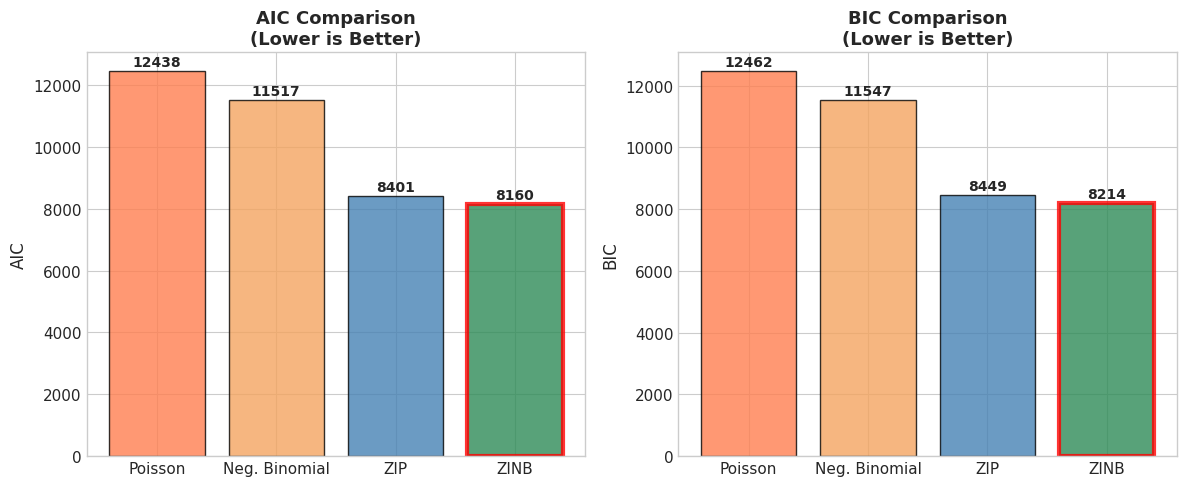

Zero-inflated models substantially outperform standard Poisson and NB.


In [18]:
# Visualize AIC/BIC comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = model_comparison['Model'].values
colors = ['coral', 'sandybrown', 'steelblue', 'seagreen']

for ax, metric in zip(axes, ['AIC', 'BIC']):
    vals = model_comparison[metric].values
    bars = ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')

    # Annotate
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + max(vals) * 0.005,
                f'{val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Highlight best
    best_idx = np.argmin(vals)
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'aic_bic_comparison_zi.png', dpi=300, bbox_inches='tight')
plt.show()

print('Zero-inflated models substantially outperform standard Poisson and NB.')

## Section 5: Predicted Probabilities and Zero Decomposition

### Predictions from ZIP/ZINB

Zero-inflated models allow us to decompose predictions:

1. **$P(\text{structural zero})$**: $\pi_i$ -- probability the individual is a never-user
2. **$P(\text{sampling zero})$**: $(1 - \pi_i) \cdot P_{\text{count}}(0)$ -- user who happened to have zero visits
3. **$P(\text{total zero})$**: $\pi_i + (1 - \pi_i) \cdot P_{\text{count}}(0)$
4. **Expected count**: $(1 - \pi_i) \cdot \lambda_i$ -- unconditional expected visits

In [19]:
# Choose the preferred model for predictions
# Use ZIP if alpha is near zero, otherwise ZINB
if zinb_result.alpha > 0.05:
    pred_model = zinb_model
    pred_params = zinb_result.params
    pred_name = 'ZINB'
else:
    pred_model = zip_model
    pred_params = zip_result.params
    pred_name = 'ZIP'

print(f'Using {pred_name} for predictions (alpha={zinb_result.alpha:.4f})')
print()

# Compute predictions
prob_structural = pred_model.predict(pred_params, which='prob-zero-structural')
prob_zero_total = pred_model.predict(pred_params, which='prob-zero')
prob_sampling_zero = pred_model.predict(pred_params, which='prob-zero-sampling')
expected_count = pred_model.predict(pred_params, which='mean')

print('PREDICTION SUMMARY')
print('=' * 60)
print(f'Average P(structural zero): {prob_structural.mean():.4f} ({prob_structural.mean()*100:.1f}%)')
print(f'Average P(sampling zero):   {prob_sampling_zero.mean():.4f} ({prob_sampling_zero.mean()*100:.1f}%)')
print(f'Average P(total zero):      {prob_zero_total.mean():.4f} ({prob_zero_total.mean()*100:.1f}%)')
print(f'Observed P(zero):           {(y == 0).mean():.4f} ({(y == 0).mean()*100:.1f}%)')
print(f'Average expected visits:    {expected_count.mean():.4f}')
print(f'Observed mean visits:       {y.mean():.4f}')
print('\nModel closely matches observed zero rate and mean.')

Using ZINB for predictions (alpha=0.3164)

PREDICTION SUMMARY
Average P(structural zero): 0.5526 (55.3%)
Average P(sampling zero):   0.0676 (6.8%)
Average P(total zero):      0.6202 (62.0%)
Observed P(zero):           0.6207 (62.1%)
Average expected visits:    1.3371
Observed mean visits:       1.3517

Model closely matches observed zero rate and mean.


In [20]:
# Decompose zeros by insurance status
decomp_rows = []
for ins_val, ins_label in [(0, 'No Insurance'), (1, 'Has Insurance')]:
    mask = df['insurance'] == ins_val
    decomp_rows.append({
        'Group': ins_label,
        'N': mask.sum(),
        'Observed Zero Rate': (y[mask] == 0).mean(),
        'P(Structural Zero)': prob_structural[mask].mean(),
        'P(Sampling Zero)': prob_sampling_zero[mask].mean(),
        'P(Total Zero)': prob_zero_total[mask].mean(),
        'P(Positive Count)': 1 - prob_zero_total[mask].mean(),
        'E[visits]': expected_count[mask].mean(),
    })

decomp_df = pd.DataFrame(decomp_rows)
print('ZERO DECOMPOSITION BY INSURANCE STATUS')
print('=' * 80)
display(decomp_df.round(4))

decomp_df.to_csv(TABLES_DIR / 'table_07_zero_decomposition.csv', index=False)

print('\nKey finding:')
print(f'  Uninsured: ~{decomp_df.iloc[0]["P(Structural Zero)"]*100:.0f}% structural zeros')
print(f'  Insured:   ~{decomp_df.iloc[1]["P(Structural Zero)"]*100:.0f}% structural zeros')
print('  Insurance primarily works through the extensive margin (access).')

ZERO DECOMPOSITION BY INSURANCE STATUS


,Group,N,Observed Zero Rate,P(Structural Zero),P(Sampling Zero),P(Total Zero),P(Positive Count),E[visits]
0,No Insurance,1058,0.7873,0.7511,0.0372,0.7883,0.2117,0.7550
1,Has Insurance,1942,0.5299,0.4444,0.0842,0.5286,0.4714,1.6543



Key finding:
  Uninsured: ~75% structural zeros
  Insured:   ~44% structural zeros
  Insurance primarily works through the extensive margin (access).


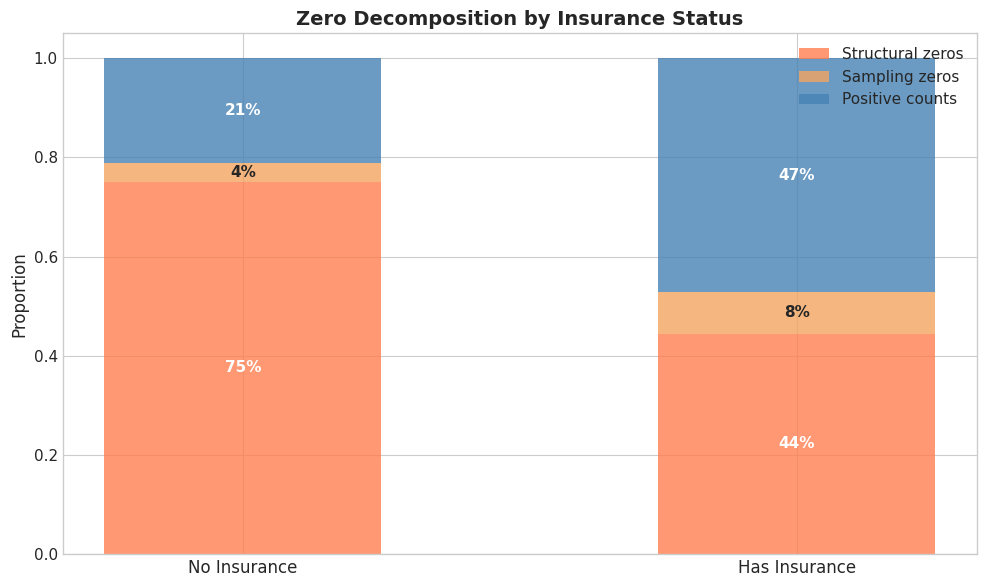

Uninsured individuals have a much larger structural zero component.
Policy: expanding insurance access reduces the structural zero barrier.


In [21]:
# Stacked bar chart: zero decomposition by insurance
fig, ax = plt.subplots(figsize=(10, 6))

groups = decomp_df['Group'].values
structural = decomp_df['P(Structural Zero)'].values
sampling = decomp_df['P(Sampling Zero)'].values
positive = decomp_df['P(Positive Count)'].values

x = np.arange(len(groups))
width = 0.5

p1 = ax.bar(x, structural, width, label='Structural zeros', color='coral', alpha=0.8)
p2 = ax.bar(x, sampling, width, bottom=structural, label='Sampling zeros',
            color='sandybrown', alpha=0.8)
p3 = ax.bar(x, positive, width, bottom=structural + sampling,
            label='Positive counts', color='steelblue', alpha=0.8)

ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Zero Decomposition by Insurance Status', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 1.05)

# Add percentage annotations
for i in range(len(groups)):
    ax.text(i, structural[i] / 2, f'{structural[i]*100:.0f}%',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    ax.text(i, structural[i] + sampling[i] / 2, f'{sampling[i]*100:.0f}%',
            ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(i, structural[i] + sampling[i] + positive[i] / 2, f'{positive[i]*100:.0f}%',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'zero_decomposition_by_insurance.png', dpi=300, bbox_inches='tight')
plt.show()

print('Uninsured individuals have a much larger structural zero component.')
print('Policy: expanding insurance access reduces the structural zero barrier.')

## Section 6: Interpretation and Policy Application

### Two Margins of Effect

Zero-inflated models identify **two distinct policy levers**:

1. **Extensive margin** (participation): Get people to use healthcare at all
   - Policy: Expand insurance, reduce distance barriers, build urban clinics

2. **Intensive margin** (frequency among users): Manage how often users visit
   - Policy: Chronic disease management, preventive care programs

In [22]:
# Counterfactual analysis: What if everyone had insurance?
print('COUNTERFACTUAL: Universal Insurance Coverage')
print('=' * 70)

# Current predictions
current_visits = expected_count.mean()
current_structural = prob_structural.mean()
current_zero = prob_zero_total.mean()

# Counterfactual: set insurance=1 for everyone
X_inflate_cf = X_inflate.copy()
X_inflate_cf[:, 1] = 1  # insurance column = 1 for all

cf_structural = pred_model.predict(
    pred_params, exog_inflate=X_inflate_cf, which='prob-zero-structural'
)
cf_zero = pred_model.predict(
    pred_params, exog_inflate=X_inflate_cf, which='prob-zero'
)
cf_visits = pred_model.predict(
    pred_params, exog_inflate=X_inflate_cf, which='mean'
)

print('\nCurrent state:')
print(f'  Insurance rate: {df["insurance"].mean()*100:.1f}%')
print(f'  P(structural zero): {current_structural*100:.1f}%')
print(f'  P(total zero): {current_zero*100:.1f}%')
print(f'  E[visits]: {current_visits:.3f}')

print('\nCounterfactual (universal insurance):')
print(f'  Insurance rate: 100%')
print(f'  P(structural zero): {cf_structural.mean()*100:.1f}%')
print(f'  P(total zero): {cf_zero.mean()*100:.1f}%')
print(f'  E[visits]: {cf_visits.mean():.3f}')

print(f'\nEffect of universal insurance:')
print(f'  Structural zeros: {(current_structural - cf_structural.mean())*100:+.1f} pp')
print(f'  Total zeros: {(current_zero - cf_zero.mean())*100:+.1f} pp')
print(f'  Expected visits: {(cf_visits.mean() - current_visits):+.3f} ({(cf_visits.mean()/current_visits - 1)*100:+.1f}%)')

COUNTERFACTUAL: Universal Insurance Coverage

Current state:
  Insurance rate: 64.7%
  P(structural zero): 55.3%
  P(total zero): 62.0%
  E[visits]: 1.337

Counterfactual (universal insurance):
  Insurance rate: 100%
  P(structural zero): 44.7%
  P(total zero): 53.1%
  E[visits]: 1.653

Effect of universal insurance:
  Structural zeros: +10.5 pp
  Total zeros: +8.9 pp
  Expected visits: +0.316 (+23.6%)


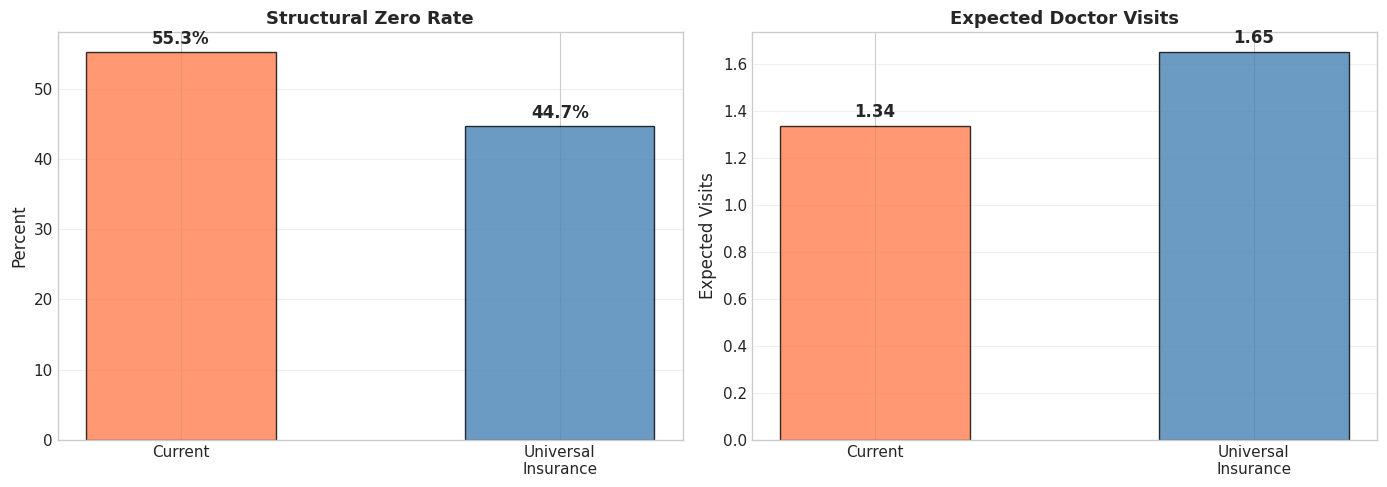

In [23]:
# Visualize counterfactual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Structural zero comparison
ax = axes[0]
scenarios = ['Current', 'Universal\nInsurance']
struct_vals = [current_structural * 100, cf_structural.mean() * 100]
bars = ax.bar(scenarios, struct_vals, color=['coral', 'steelblue'],
              alpha=0.8, edgecolor='black', width=0.5)
ax.set_ylabel('Percent', fontsize=12)
ax.set_title('Structural Zero Rate', fontsize=13, fontweight='bold')
for bar, val in zip(bars, struct_vals):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Expected visits comparison
ax = axes[1]
visit_vals = [current_visits, cf_visits.mean()]
bars = ax.bar(scenarios, visit_vals, color=['coral', 'steelblue'],
              alpha=0.8, edgecolor='black', width=0.5)
ax.set_ylabel('Expected Visits', fontsize=12)
ax.set_title('Expected Doctor Visits', fontsize=13, fontweight='bold')
for bar, val in zip(bars, visit_vals):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.02,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'counterfactual_universal_insurance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save policy implications
policy_df = pd.DataFrame({
    'Scenario': ['Current', 'Universal Insurance'],
    'Insurance Rate': [f"{df['insurance'].mean()*100:.1f}%", '100%'],
    'P(Structural Zero)': [current_structural, cf_structural.mean()],
    'P(Total Zero)': [current_zero, cf_zero.mean()],
    'E[visits]': [current_visits, cf_visits.mean()],
})
policy_df.to_csv(TABLES_DIR / 'table_08_policy_implications.csv', index=False)

## Section 7: When to Use Zero-Inflated Models

### Decision Framework

**Use ZIP/ZINB if:**
1. Observed zeros **significantly exceed** Poisson/NB predictions
2. There is a **theoretical justification** for two types of zeros
3. The **Vuong test** is significant (V > 1.96)
4. Distinct covariates can be identified for inflation vs count

**Don't use if:**
1. Zeros are not excessive (standard Poisson/NB handles them fine)
2. No theoretical reason for two processes
3. Sample size is too small for reliable estimation

### ZIP vs ZINB

| Feature | ZIP | ZINB |
|---------|-----|------|
| Count part | Poisson (equidispersion) | NB (allows overdispersion) |
| Parameters | $\beta + \gamma$ | $\beta + \gamma + \alpha$ |
| When to use | No overdispersion in counts | Overdispersion in counts |
| Decision rule | Default choice | If Var/Mean > 1 among non-zeros |

### ZIP vs Hurdle Model

- **ZIP**: Zeros come from **two sources** (structural + sampling)
- **Hurdle**: All zeros from **one process**, then conditional count for y > 0
- Hurdle is appropriate when "participated or not" is the key distinction

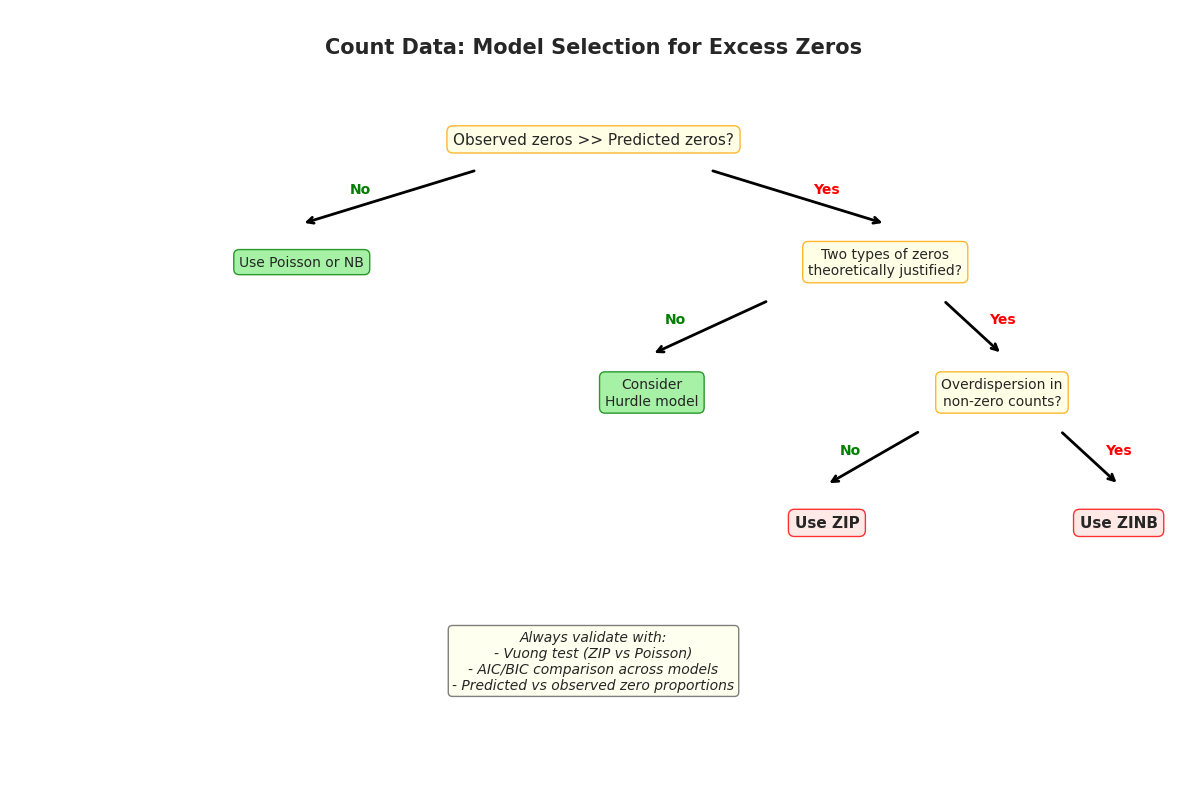

In [24]:
# Decision tree visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

box = dict(boxstyle='round,pad=0.5', facecolor='lightblue', edgecolor='navy', alpha=0.8)
decision = dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='orange', alpha=0.8)
result_g = dict(boxstyle='round,pad=0.4', facecolor='lightgreen', edgecolor='green', alpha=0.8)
result_r = dict(boxstyle='round,pad=0.4', facecolor='mistyrose', edgecolor='red', alpha=0.8)

ax.text(5, 9.5, 'Count Data: Model Selection for Excess Zeros',
        fontsize=15, fontweight='bold', ha='center', va='center')

# Step 1
ax.text(5, 8.3, 'Observed zeros >> Predicted zeros?', fontsize=11,
        ha='center', va='center', bbox=decision)
ax.annotate('', xy=(2.5, 7.2), xytext=(4.0, 7.9),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(3.0, 7.6, 'No', fontsize=10, ha='center', color='green', fontweight='bold')
ax.annotate('', xy=(7.5, 7.2), xytext=(6.0, 7.9),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(7.0, 7.6, 'Yes', fontsize=10, ha='center', color='red', fontweight='bold')

# Left: standard models
ax.text(2.5, 6.7, 'Use Poisson or NB', fontsize=10,
        ha='center', va='center', bbox=result_g)

# Right: check theory
ax.text(7.5, 6.7, 'Two types of zeros\ntheoretically justified?', fontsize=10,
        ha='center', va='center', bbox=decision)
ax.annotate('', xy=(5.5, 5.5), xytext=(6.5, 6.2),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(5.7, 5.9, 'No', fontsize=10, ha='center', color='green', fontweight='bold')
ax.annotate('', xy=(8.5, 5.5), xytext=(8.0, 6.2),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(8.5, 5.9, 'Yes', fontsize=10, ha='center', color='red', fontweight='bold')

ax.text(5.5, 5.0, 'Consider\nHurdle model', fontsize=10,
        ha='center', va='center', bbox=result_g)
ax.text(8.5, 5.0, 'Overdispersion in\nnon-zero counts?', fontsize=10,
        ha='center', va='center', bbox=decision)

ax.annotate('', xy=(7.0, 3.8), xytext=(7.8, 4.5),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(7.2, 4.2, 'No', fontsize=10, ha='center', color='green', fontweight='bold')
ax.annotate('', xy=(9.5, 3.8), xytext=(9.0, 4.5),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(9.5, 4.2, 'Yes', fontsize=10, ha='center', color='red', fontweight='bold')

ax.text(7.0, 3.3, 'Use ZIP', fontsize=11,
        ha='center', va='center', bbox=result_r, fontweight='bold')
ax.text(9.5, 3.3, 'Use ZINB', fontsize=11,
        ha='center', va='center', bbox=result_r, fontweight='bold')

# Note
ax.text(5, 1.5, 'Always validate with:\n'
        '- Vuong test (ZIP vs Poisson)\n'
        '- AIC/BIC comparison across models\n'
        '- Predicted vs observed zero proportions',
        fontsize=10, ha='center', va='center', style='italic',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'decision_tree_zero_inflated.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 8: Summary

### Key Takeaways

1. **Zero-inflated models** handle excess zeros by modeling two distinct processes
2. **Structural zeros** (never-users) are distinct from **sampling zeros** (potential users with y=0)
3. **ZIP** = Logit (inflation) + Poisson (count) -- use when count part is equidispersed
4. **ZINB** = Logit (inflation) + NB (count) -- use when overdispersion remains in count part
5. **Vuong test** formally compares ZIP vs standard Poisson
6. **Distinct covariates** can identify the two processes (e.g., access barriers for inflation, health for counts)
7. **Counterfactual analysis** reveals policy effects through two margins

### PanelBox Workflow

```python
from panelbox.models.count import (
    ZeroInflatedPoisson,
    ZeroInflatedNegativeBinomial
)

# ZIP
zip_model = ZeroInflatedPoisson(
    endog=y,
    exog_count=X_count,
    exog_inflate=Z_inflate,
    exog_count_names=['const', 'age', 'income', 'chronic'],
    exog_inflate_names=['const', 'insurance', 'distance', 'urban'],
)
zip_result = zip_model.fit()

# Vuong test (built-in)
print(f'Vuong stat: {zip_result.vuong_stat}')

# Predictions
prob_struct = zip_model.predict(zip_result.params, which='prob-zero-structural')
expected = zip_model.predict(zip_result.params, which='mean')
```

### Next Steps

Notebook 06 (Marginal Effects) will show how to compute marginal effects for all count models including ZIP/ZINB.

### References

- Lambert, D. (1992). Zero-inflated Poisson regression. *Technometrics*, 34(1), 1-14.
- Vuong, Q. H. (1989). Likelihood ratio tests for model selection. *Econometrica*, 307-333.
- Greene, W. H. (1994). Accounting for excess zeros. Working paper, NYU.
- Mullahy, J. (1986). Specification and testing of modified count data models. *J. Econometrics*.
- Deb, P. & Trivedi, P. K. (1997). Demand for medical care by the elderly. *J. Applied Econometrics*.
- Cameron, A. C. & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge.

## Exercises

1. **Alternative inflation covariates**: Try adding `age` or `chronic_condition` to the inflation model. Does it improve fit? Is it theoretically justified?

2. **Same covariates**: Estimate ZIP with the same covariates in both parts. Compare AIC with the specification using different covariates.

3. **Manual Vuong test**: Implement the Vuong test manually by computing per-observation log-likelihoods for ZIP and Poisson, then computing the test statistic.

4. **Distance effect**: Create a plot showing how P(structural zero) changes as distance to clinic increases from 1 to 80 km, holding other inflation covariates at their means.

5. **Zero decomposition by region**: Extend the decomposition analysis to compare urban vs rural, and by distance quartiles.

Solutions available in `solutions/05_zero_inflated_solutions.ipynb`

In [25]:
# Exercise solutions template

# Exercise 1: Alternative inflation covariates
# [Your code here]

# Exercise 2: Same covariates in both parts
# [Your code here]

# Exercise 3: Manual Vuong test
# [Your code here]

# Exercise 4: Distance effect plot
# [Your code here]

# Exercise 5: Decomposition by region
# [Your code here]